Fetched 1256 records for AAPL
Fetched 1256 records for MSFT
Fetched 1256 records for GOOGL
Fetched 1256 records for AMZN

--- Basic Dataset Information ---
Shape: (1256, 7)

Columns:
['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']

Data types:
Open            float64
High            float64
Low             float64
Close           float64
Volume            int64
Dividends       float64
Stock Splits    float64
dtype: object

---Missing Values---
No missing value

---Basic statistics---
              Open         High          Low        Close        Volume    Dividends  Stock Splits
count  1256.000000  1256.000000  1256.000000  1256.000000  1.256000e+03  1256.000000   1256.000000
mean    158.678577   160.418259   157.036637   158.813412  8.507628e+07     0.003646      0.003185
std      41.644546    41.891386    41.419051    41.697321  4.645000e+07     0.028745      0.112867
min      55.350231    55.452156    51.595986    54.449890  2.323470e+07     0.000000      0

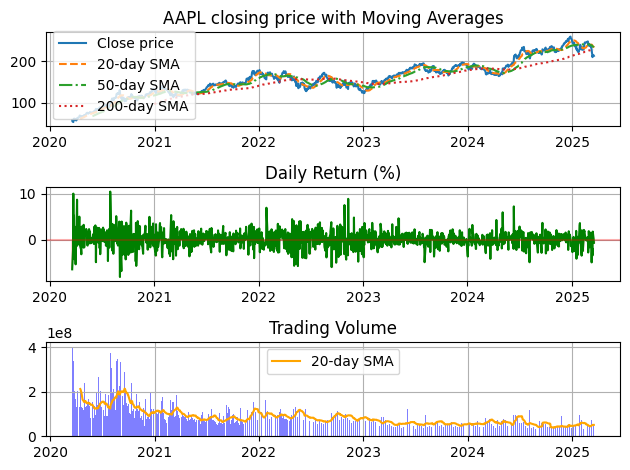

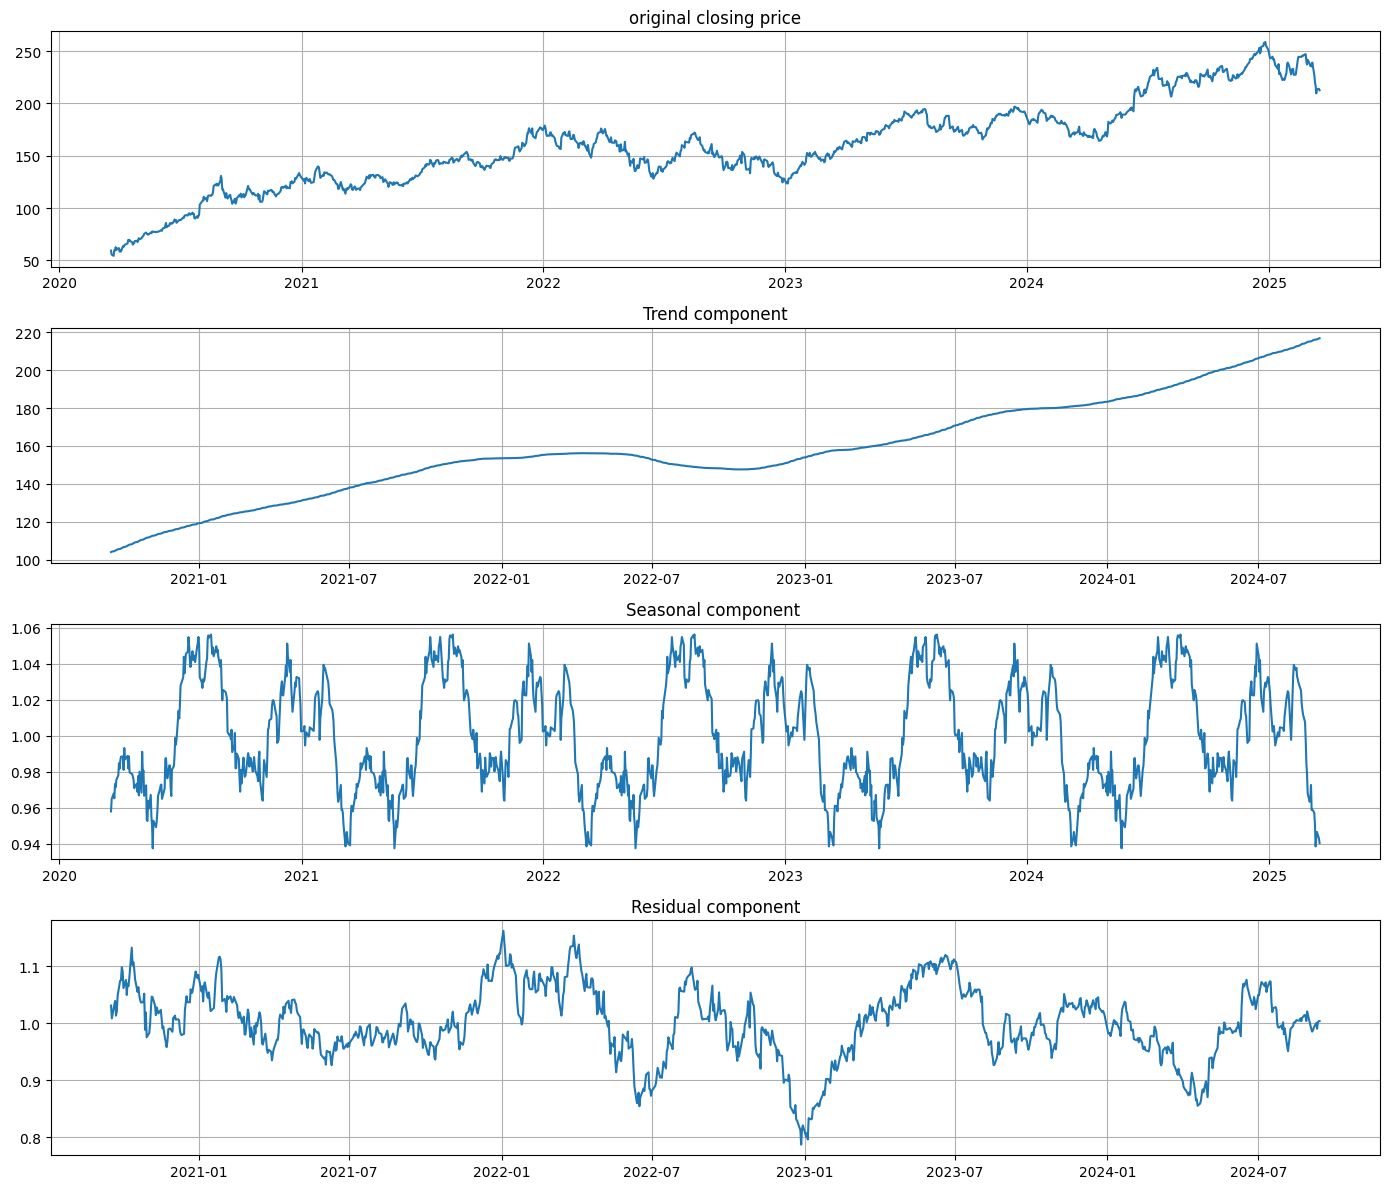

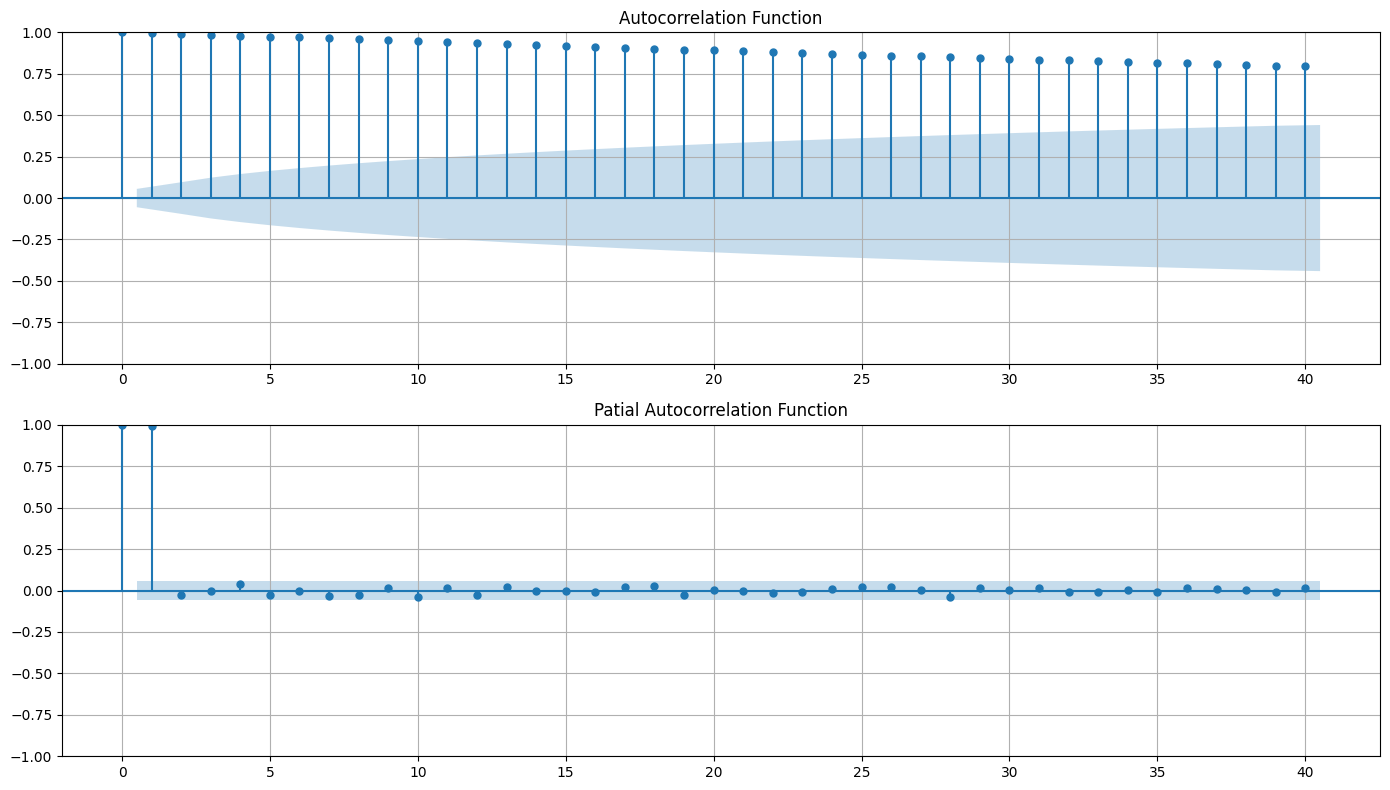

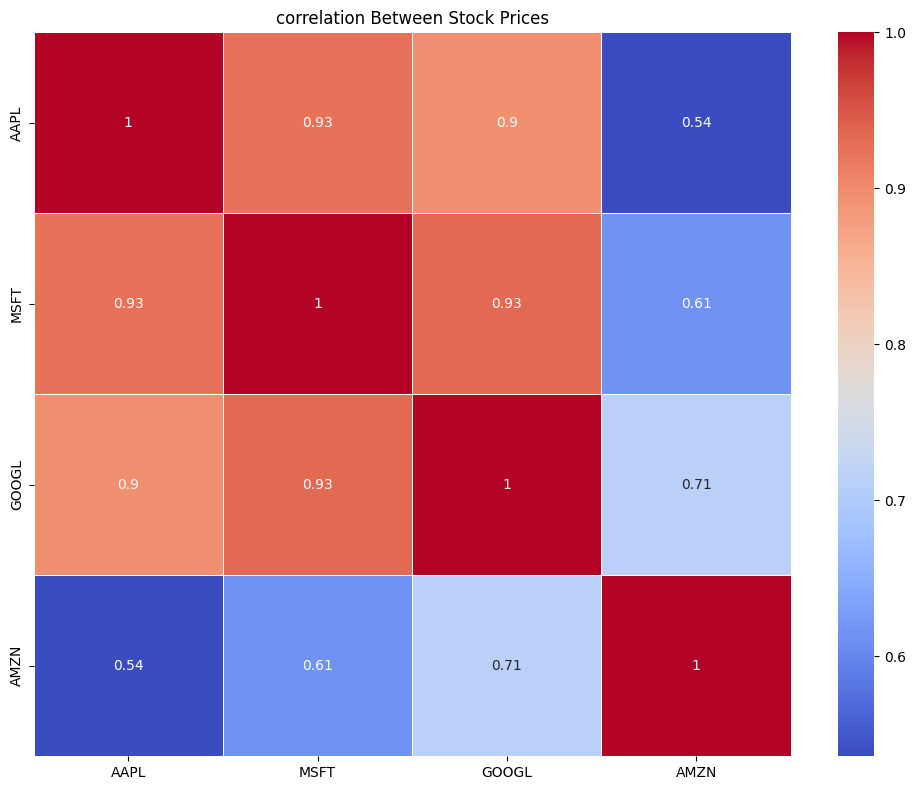

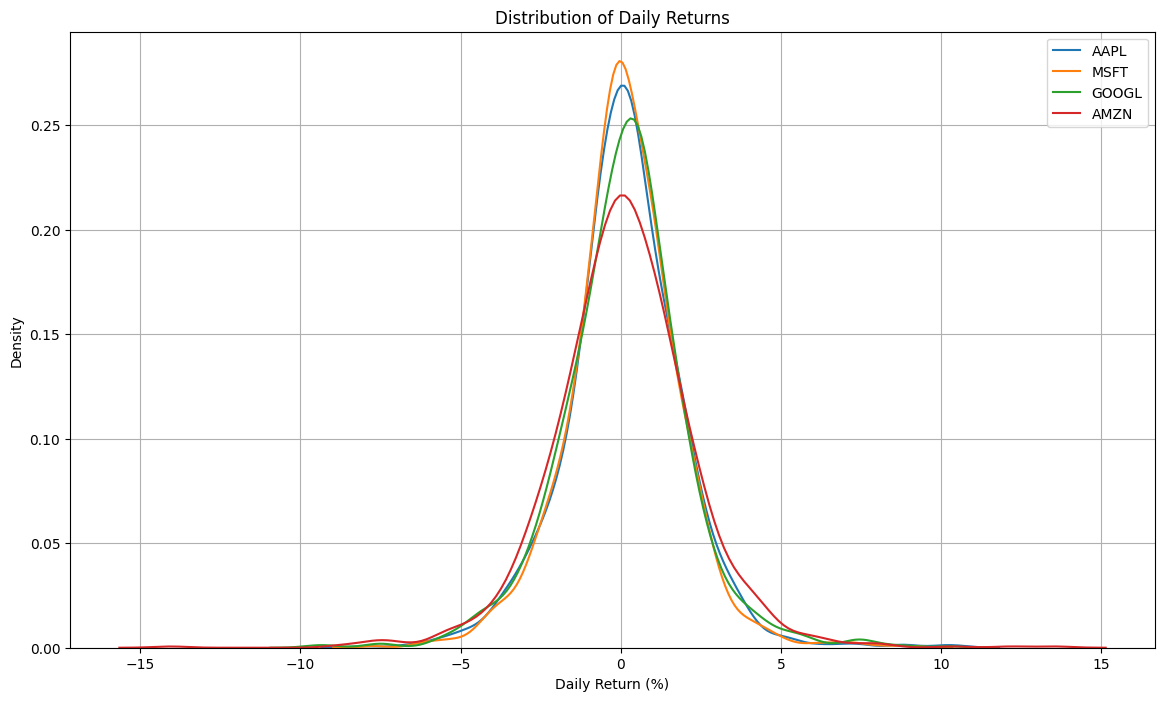

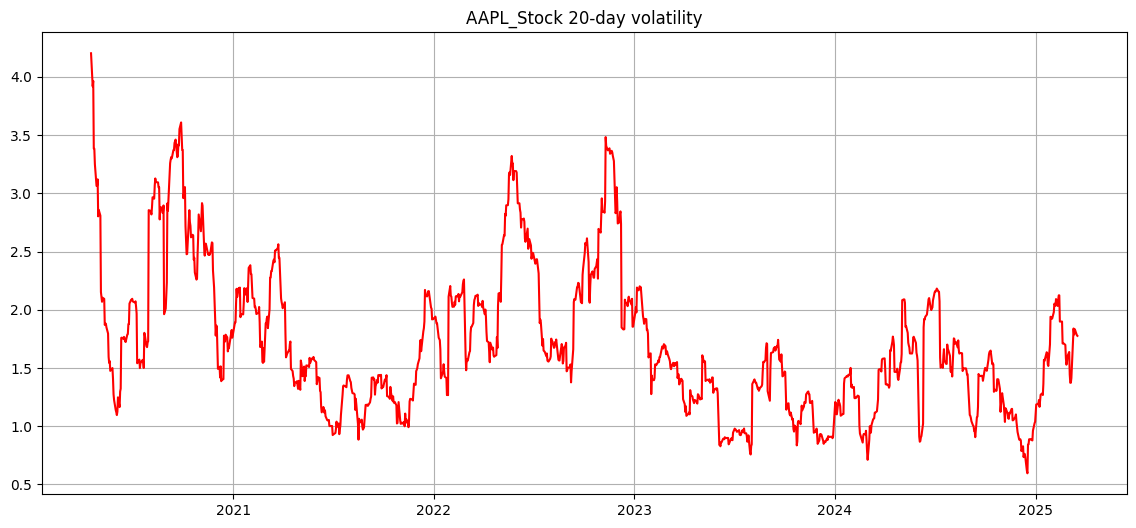


--- Risk Analysis---
Annualized Volatility: 29.45%
Sharpe Ratio: 0.91
Maximum Drawdown: -30.91%
Peak Date: 2022-01-03 00:00:00-05:00
Bottom Date: 2023-01-05 00:00:00-05:00
Recovery Date: 2023-06-02 00:00:00-04:00

Data exploration complete. Results saved as PNG files and processed data saved as CSV.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
from statistics import stdev
import seaborn as sns
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio


# set display option 
pd.set_option('display.max_columns' , None)
pd.set_option('display.width' , 1000)

# function to fetch stock data 
def get_stock_data(ticker, period="5y" , interval="1d"):

    #  Fetch historical stock data for the given ticker
    
    # Parameters:
    # ticker (str): Stock ticker symbol
    # period (str): Time period to fetch data for (e.g., '1d', '5y')
    # # interval (str): Data interval (e.g., '1d', '1h') 

    # Return:
    # pd.DataFrame:Historical stock data

    stock = yf.Ticker(ticker)
    df = stock.history(period=period, interval=interval)
    return df

# fetch data for example stocks
tickers = ['AAPL','MSFT','GOOGL','AMZN']
stock_data = {}

for ticker in tickers:
    stock_data[ticker] = get_stock_data(ticker)
    print(f"Fetched {len(stock_data[ticker])} records for {ticker}")

# # Let's explore AAPL as an example
df = stock_data['AAPL'].copy()

# # Basic information about the dataset
print("\n--- Basic Dataset Information ---")
print(f"Shape: {df.shape}")
print("\nColumns:")
print(df.columns.tolist())
print("\nData types:")
print(df.dtypes)

# check for missing values
print("\n---Missing Values---")
missing_value = df.isnull().sum()
print(missing_value[missing_value > 0] if missing_value.sum() > 0 else "No missing value" )

# Basic statistics 
print("\n---Basic statistics---")
print(df.describe())

# Time range 
print("\n--- Time Range ---")
print(f"start date: {df.index.min()}")
print(f"End date: {df.index.max()}")
print(f"Total trading days:{len(df)}")

# Calculate daily returns
df['Daily_Return'] = df['Close'].pct_change() *100
print("\n---Return statistics ---")
print(df['Daily_Return'].describe())


# Create some technical indicators
# simple Moving Averages
df['SMA20'] =df['Close'].rolling(window=20).mean()
df['SMA50'] = df['Close'].rolling(window=50).mean()
df['SMA200'] = df['Close'].rolling(window=200).mean()

df['Volatility'] = df['Daily_Return'].rolling(window=20).apply(lambda x: np.std(x, ddof=1))

# trading volume analysis 
df['Volume_SMA20'] = df['Volume'].rolling(window=20).mean()

# # Visualize the closing price and volume 
# plt.figure(figsize=(14,10))
# plt.plot

# plot 1 : Closing price with moving averages 
plt.subplot(3,1,1)
plt.plot(df['Close'], label='Close price')
plt.plot(df['SMA20'], label='20-day SMA', linestyle='--')
plt.plot(df['SMA50'], label='50-day SMA', linestyle='-.')
plt.plot(df['SMA200'],label='200-day SMA', linestyle=':')
plt.title('AAPL closing price with Moving Averages')
plt.legend()
plt.grid(True)

# plot 2: Daily return 
plt.subplot(3, 1, 2)
plt.plot(df['Daily_Return'], color='green')
plt.axhline(y=0, color='r',linestyle='-',alpha=0.3)
plt.fill_between(df.index, df['Daily_Return'], 0, 
                 where=(df['Daily_Return'] >=0), color='green', alpha=0.3)
plt.fill_between(df.index, df['Daily_Return'], 0,
                 where=(df['Daily_Return'] < 0), color='red', alpha=0.3)
plt.title('Daily Return (%)')
plt.grid(True)

# plot 3: Volume
plt.subplot(3, 1, 3)
plt.bar(df.index, df['Volume'], color='blue', alpha=0.5)
plt.plot(df['Volume_SMA20'], color='orange', label='20-day SMA')
plt.title('Trading Volume')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('appl_overview.png')
plt.show

# Seasonal Decomposition
decomposition = seasonal_decompose(df['Close'], model='multplicative', period=252)  

plt.figure(figsize=(14, 12))
plt.subplot(4, 1, 1)
plt.plot(df['Close'])
plt.title('original closing price')
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend)
plt.title('Trend component')
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal)
plt.title('Seasonal component ')
plt.grid(True)

plt.subplot(4,1,4)
plt.plot(decomposition.resid)
plt.title('Residual component')
plt.grid(True)

plt.tight_layout()
plt.savefig('seasonal_decomposition.png')
plt.show()

# Autocorrelation and partial Autocorrelation
plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
plot_acf(df['Close'].dropna(), lags=40, ax=plt.gca())
plt.title('Autocorrelation Function')
plt.grid(True)

plt.subplot(2, 1, 2)
plot_pacf(df['Close'].dropna(), lags=40, ax=plt.gca())
plt.title('Patial Autocorrelation Function')
plt.grid(True)

plt.tight_layout()
plt.savefig('acf_pacf.png')
plt.show

# Correlation between different stocks
close_prices = pd.DataFrame()
for ticker, data in stock_data.items():
    close_prices[ticker] = data['Close']

correlation = close_prices.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm',linewidths=0.5)
plt.title('correlation Between Stock Prices')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()

# Distribution of Daily returns
plt.figure(figsize=(14, 8))

for ticker, data in stock_data.items():
    returns = data['Close'].pct_change().dropna()* 100
    sns.kdeplot(returns, label=ticker)

plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return (%)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.savefig('return_distibution.png')
plt.show()

# Interactive Candlestick chart with plotly
# Last 6month of data 
recent_data = df.iloc[-126:]

fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    vertical_spacing=0.03,subplot_titles=('Candlestick', 'Volume'),
                    row_width=[0.2,0.7])

# candlestick chart
fig.add_trace(go.Candlestick(
    x=recent_data.index,
    open=recent_data['Open'],
    high=recent_data['High'],
    low=recent_data['Low'],
    close=recent_data['Close'],
    name='Price'
), row=1, col=1)
                    # 
# Add moving averages to candlesticks chart 
fig.add_trace(go.Scatter(x=recent_data.index, y=recent_data['SMA20'], line=dict(color='purple' , width=1),name='20-day MA'), row=1,col=1)
fig.add_trace(go.Scatter(x=recent_data.index,y=recent_data['SMA50'],line=dict(color='blue',width=1),name='50-day MA'),row=1, col=1)

# Volume chart
fig.add_trace(go.Bar(x=recent_data.index, y=recent_data['Volume'], name='Volume',marker_color='rgba(0, 0,255, 0.5)'), row=2, col=1)

# update layout
fig.update_layout(
    title='AAPL Stock price (Last 6 Months)',
    yaxis_title='price ($)',
    yaxis2_title='Volume',
    xaxis_rangeslider_visible=False,
    height=800,
    width=1200
)

# Hide rangeslider
fig.update_layout(xaxis_rangeslider_visible=False)

# open in your default browser
pio.renderers.default = "browser"
# show the interactive plot 
fig.show()
# save the figure as HTML
fig.write_html('interactive_chart.html')

# volitility analysis
plt.figure(figsize=(14, 6))
plt.plot(df['Volatility'],color='red')
plt.title('AAPL_Stock 20-day volatility')
plt.grid(True)
plt.savefig('volatility.png')
plt.show()

# Calculate risk-adjusted returns
risk_free_rate = ((0.03)/ (252))
excess_returns = df['Daily_Return'] / 100 - risk_free_rate
sharpe_ratio = np.sqrt(252) * (excess_returns.mean()/excess_returns.std())

print("\n--- Risk Analysis---")
print(f"Annualized Volatility: {df['Daily_Return'].std() * np.sqrt(252):.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

def calculate_max_drawdown(price_series):
    """Calculate the Maximum drawdown of a price series"""
    if len(price_series) == 0:
        return {
            'max_drawdown': None,
            'max_drawdown_date': None,
            'peak_date': None,
            'recovery_date': None
        }
    
    # Calculate the cumulative maximum of the price series
    running_max = price_series.cummax()
    
    # Calculate the drawdown in percentage terms
    drawdown = (price_series / running_max - 1) * 100
    
    # Check if drawdown contains valid values
    if drawdown.isna().all():
        return {
            'max_drawdown': None,
            'max_drawdown_date': None,
            'peak_date': None,
            'recovery_date': None
        }
    
    # Find the maximum drawdown
    max_drawdown = drawdown.min()
    
    # Find when the maximum drawdown occurred
    max_drawdown_date = drawdown.idxmin()
    
    # Find the peak before the maximum drawdown
    peak_date = price_series.loc[:max_drawdown_date].idxmax()
    
    # Find when the drawdown recovered
    try:
        # Get the index position of max_drawdown_date, not the value itself
        max_dd_pos = price_series.index.get_loc(max_drawdown_date)
        # Create a slice using integer position
        after_max_dd = price_series.iloc[max_dd_pos:]
        # Get the peak value
        peak_value = price_series.loc[peak_date]
        # Find where price recovers to peak value
        recovery_indices = after_max_dd[after_max_dd >= peak_value].index
        recovery_date = recovery_indices[0] if len(recovery_indices) > 0 else None
    except (IndexError, KeyError):
        recovery_date = None
    
    return {
        'max_drawdown': max_drawdown,
        'max_drawdown_date': max_drawdown_date,
        'peak_date': peak_date,
        'recovery_date': recovery_date
    }
drawdown_info = calculate_max_drawdown(df['Close'])
print(f"Maximum Drawdown: {drawdown_info['max_drawdown']:.2f}%")
print(f"Peak Date: {drawdown_info['peak_date']}")
print(f"Bottom Date: {drawdown_info['max_drawdown_date']}")
print(f"Recovery Date: {drawdown_info['recovery_date'] if drawdown_info['recovery_date'] else 'Not yet recovered'}")


# save cleaned data for modelling 
df.to_csv('aapl_2_processed.csv')

print("\nData exploration complete. Results saved as PNG files and processed data saved as CSV.")


In [ ]:
# # Maximum drawdown 
# def calculate_max_drawdown(price_series):
#     """Calculate the Maximum drawdown of a price series"""
#     if len(price_series) == 0:
#         return {
#             'max_drawdown': None,
#             'max_drawdown_date': None,
#             'peak_date': None,
#             'recovery_date': None
#         }
    
#     # Calculate the cumulative maximum of the price series 
#     running_max = price_series.cummax()
#     # Calculate the drwdown is percentage terms
#     drawdown = (price_series/ running_max - 1 ) * 100
#    # check if drawdown contains valid values 
#     if drawdown.isna().all():
#         return {
#              'max_drawdown': None,
#             'max_drawdown_date': None,
#             'peak_date': None,
#             'recovery_date': None
#         }
#     # find the maximum drawdown
#     max_drawdown = drawdown.min()
#     # find when the maximum dradown occured 
#     max_drawdown_date = drawdown.idxmin()
#     # find the peak before the maximum drawdown
#     peak_date = price_series.loc[:max_drawdown_date].idxmax()
#     # Find when the drawdown recovered
#     try:
#         recovery_date = price_series.loc[max_drawdown:].loc[price_series> running_max.loc[max_drawdown_date]].index[0]
        
#     except IndexError:
#         recovery_date =  None

#     return {
#         'max_drawdown' : max_drawdown,
#         'max_drawdown_date' : max_drawdown_date,
#         'peak_date' : peak_date,
#         'recovery_date' : recovery_date
#     }
# # Calaculating_max_drawdown 'Close' price
# drawdown_info = calculate_max_drawdown(df['Close'])
# print(f"Maximum Drawdown: {drawdown_info['max_drawdown']:.2f}%")
# print(f"Peak Date: {drawdown_info['peak_date']}")
# print(f"Bottom Date: {drawdown_info['max_drawdown_date']}")
# print(f"Recovery Date: {drawdown_info['recovery_date'] if drawdown_info['recovery_date'] else 'Not yet recovered'}")